In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-08-17 16:29:56.337776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

**Verif**
* CSI (critical success index) = tp/(tp+fn+fp)
* POFD (probability of false detection) = fp/(tn+fp)

In [4]:
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI
    
    POFD = fp/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    print('{} {} {}'.format(CSI, POFD, AUC))
    metric = 0.2*POFD + 0.7*CSI_metric + 0.1*AUC_metric


    return metric

In [5]:
flag_sparse = [0, 2, 3, 4, 10, 11, 12,]

In [6]:
filename_aug = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_aug/*.npy"))
filename_full = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*.npy"))

cut_train_aug = 136000
cut_train_full = 2848299

filename_train_aug = filename_aug[:cut_train_aug]
filename_train_full = filename_full[:cut_train_full]

L_valid_aug = 50
L_valid_full = 30000

filename_valid_aug = filename_aug[-L_valid_aug:]
filename_valid_full = filename_full[-L_valid_full:]

In [7]:
L_vars = 19
grid_shape = (128, 128)

L_valid = L_valid_aug+L_valid_full

VALID_input = np.empty((L_valid,)+grid_shape+(L_vars,))
VALID_target = np.empty(L_valid)
for i, filename in enumerate(filename_valid_aug+filename_valid_full):
    data = np.load(filename)
    VALID_input[i, ...] = data[..., :L_vars]
    if 'pos' in filename:
        VALID_target[i] = True
    elif 'neg' in filename:
        VALID_target[i] = False
    else:
        aergheagtha

In [8]:
IN = tf.keras.Input((128, 128, 19))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)
#D = tf.keras.layers.Softmax()(D)

OUT = D

2022-08-17 16:51:52.075212: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-17 16:51:52.364750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-17 16:51:52.456637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-17 16:51:52.457335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-17 16:51:52.653676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-17 16:51:52.671441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [9]:
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-5))

In [10]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

In [11]:
#batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG_X'

model_name = '{}_pp20_tune'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-5))

model_name = '{}_pp20_tune2'.format(key)
model_path = temp_dir+model_name

In [12]:
Y_pred = model.predict([VALID_input,])
record = verif_metric(VALID_target, Y_pred)
print("Initial record: {}".format(record))

2022-08-17 17:15:28.743491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-17 17:15:28.754266: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-08-17 17:15:30.555695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-17 17:15:31.601717: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


0.1919191919191919 0.004933333333333333 0.976826
Initial record: 0.5689606323232324


In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
batch_size_full = 97
batch_size_aug = batch_size - batch_size_full

X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [ ]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

L_full = len(filename_train_full)
L_aug = len(filename_train_aug)

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_full = du.shuffle_ind(L_full)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_full = []
        for ind_temp in ind_full[:batch_size_full]:
            file_pick_full.append(filename_train_full[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:batch_size_aug]:
            file_pick_aug.append(filename_train_aug[ind_temp])
        
        file_pick = file_pick_full + file_pick_aug
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[..., :L_vars]
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    record_temp = verif_metric(VALID_target, Y_pred, thres=0.5)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


0.336734693877551 0.0016 0.966348
Validation loss improved from 0.5689606323232324 to 0.46797091428571425
save to: /glade/work/ksha/NCAR/Keras_models/VGG_X_pp20_tune2


2022-08-17 17:51:22.840273: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_X_pp20_tune2/assets
--- 1916.28848528862 seconds ---
0.13793103448275862 0.008 0.9800623333333334
Validation loss 0.6070420425287355 NOT improved
0.15810276679841898 0.0067666666666666665 0.9757666666666667
Validation loss 0.5931047299077733 NOT improved


In [41]:
#batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG_X'

model_name = '{}_pp20_tune'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-5))

model_name = '{}_pp20_tune2'.format(key)
model_path = temp_dir+model_name

In [51]:
Y_pred = model.predict([VALID_input,])

record_temp = verif_metric(VALID_target, Y_pred)

print(record_temp)

0.37735849056603776 0.012444444444444444 0.9638394444444445
0.44195400104821797


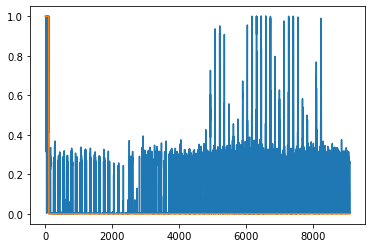

In [43]:
plt.plot(Y_pred.ravel())
plt.plot(VALID_target.ravel())

In [ ]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        # add noise within sparse inputs
        for v in flag_sparse:
            X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))
        
        # Soft labelling
        Y_batch[:batch_size_half, :] = np.random.uniform(0.95, 0.99, size=(batch_size_half, 1))
        Y_batch[batch_size_half:, :] = np.random.uniform(0.01, 0.05, size=(batch_size_half, 1))
        
        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Validation loss improved from 0.10423514726151162 to 0.10333990957147299
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune/assets
--- 426.8856997489929 seconds ---
Validation loss improved from 0.10333990957147299 to 0.10320518073099194
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune/assets
--- 419.2100965976715 seconds ---
Validation loss 0.10328869685433106 NOT improved
Validation loss improved from 0.10320518073099194 to 0.10284800485759182
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune/assets
--- 415.4635727405548 seconds ---
Validation loss 0.10373923745052083 NOT improved
Validation loss 0.10341869836707596 NOT improved
Validation loss 0.10376648524233334 N

In [50]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'TH_chad'
model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [9]:
from sklearn.metrics import classification_report, auc, roc_curve

In [53]:
#filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
#filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [54]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = 20
L_sparse = len(flag_sparse)
L_dense = L_vars - L_sparse

VALID_sparse = np.empty((L_valid,)+grid_shape+(L_sparse,))
VALID_dense = np.empty((L_valid,)+grid_shape+(L_dense,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    count0 = 0
    count1 = 0
    for v in range(L_vars):
        if v in flag_sparse:
            VALID_sparse[i, ..., count0] = data[..., v]
            count0 += 1
        else:
            VALID_dense[i, ..., count1] = data[..., v]
            count1 += 1

In [60]:
VALID_label

array([1., 1., 1., ..., 0., 0., 0.])

In [55]:
# filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
# label_pos = np.ones(len(filename_valid_pos))
# label_neg = np.zeros(len(filename_valid_neg))
# VALID_label_skew = np.hstack([label_pos, label_neg])

# L_valid = len(VALID_label_skew)

# VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

# for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
#     data = np.load(filename)
#     VALID_skew[i, ...] = data[...]

**Balanced verif**

In [56]:
Y_pred = model.predict([VALID_dense, VALID_sparse])
Y_pred_label = Y_pred > 0.5

2022-08-11 17:58:34.004253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 47110422528 exceeds 10% of free system memory.


In [57]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69     55296
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53     55296
   macro avg       0.50      0.27      0.35     55296
weighted avg       1.00      0.53      0.69     55296



/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83     33142
        True       0.72      0.84      0.77     22154

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [58]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.9319409017491813

In [17]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [18]:
fpr.shape

(17970,)

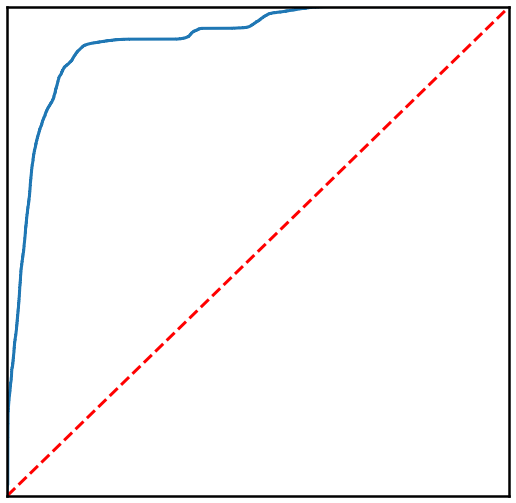

In [61]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

**Natural verif**

In [25]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5
print(classification_report(Y_pred_label.ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92     26640
        True       0.67      0.33      0.44      5328

    accuracy                           0.86     31968
   macro avg       0.78      0.65      0.68     31968
weighted avg       0.84      0.86      0.84     31968



In [26]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8685229089653266

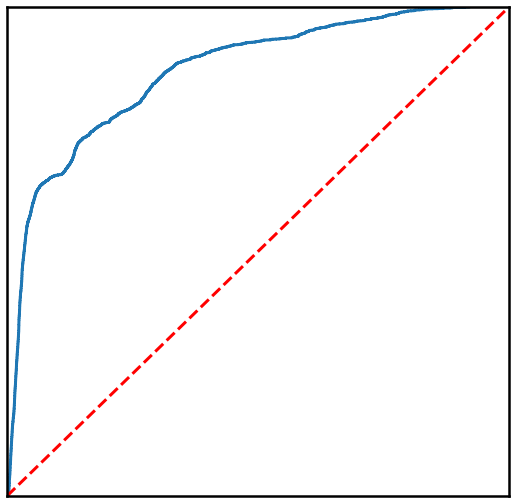

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

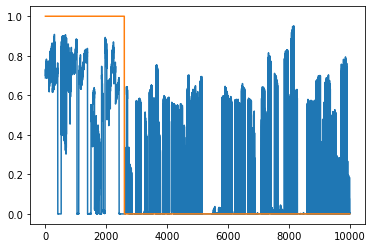

In [40]:
plt.plot(Y_pred.ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])

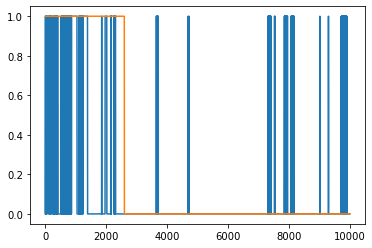

In [42]:
plt.plot(Y_pred.ravel()[:10000]>0.7)
plt.plot(VALID_label_skew.ravel()[:10000])